# <center>tf.KerasによるSkip-GANomaly</center>

異常検知を実装して見ましょう。このコードを元にGANomalyなども簡単に実装できるので、性能を比較してみると良い。



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


今回使うモデルのサイズと深さを決めておきましょう：

In [ ]:
SIZE = 32#128
DEPTH = 4
DATASET_PATH = '/content/drive/My Drive/datasets'

# 1. モデルの作成

ジェネレータはUNetベースなので、もう勉強済みなので実装は簡単。ただ今回はインスタンス規格化を使うので、TensorFlow Addonsをインストールする。

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 19.0MB/s 


以下の部品は、ほぼ以前のUNetの実装の通り：

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.initializers import RandomNormal

gamma_initializer = RandomNormal(mean=0.0, stddev=0.02)

def conv_block(inputs, kernel_size=(3,3), n_channels=32):
    
    # Convを二回行う
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(inputs)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    return x

def upconv_block(inputs, n_channels=32):
    
    # Upsamplingでサイズを倍にした後、2x2 Convでチャネル数を変更。TransposeConvを使うのでも良い
    x = layers.UpSampling2D((2, 2))(inputs)
    x = layers.Conv2D(n_channels, (2,2), padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [ ]:
def build_unet(size=(256,256,1), depth=4, n_classes=3):

    channels = [64 * 2**i for i in range(depth+1)]

    x_in = layers.Input(size)
    x = x_in

    downsampling_layers = []

    for i, c in enumerate(channels[:-1]):
        x_unpool = conv_block(inputs=x, n_channels=c)
        if i == (depth-1):
            x_unpool = layers.Dropout(0.5)(x_unpool)
        downsampling_layers.append(x_unpool)
        x = layers.MaxPooling2D((2,2))(x_unpool)

    x = conv_block(inputs=x, n_channels=channels[-1])
    x = layers.Dropout(0.5)(x)

    channels = channels[:-1][::-1]
    downsampling_layers = downsampling_layers[::-1]

    for i, c in enumerate(channels):
        x = upconv_block(inputs=x, n_channels=c)
        x = layers.Concatenate()([x, downsampling_layers[i]])
        #x = conv_block(inputs=x, n_channels=c)
        x = layers.Conv2D(c, kernel_size=(3,3), padding='same')(x)
        x = InstanceNormalization()(x)
        x = layers.Activation('relu')(x)

    x = layers.Conv2D(n_classes, (1,1), padding='same', activation='tanh')(x)

    return Model(inputs=x_in, outputs=x)

DCGANと基本変わらないので、ディスクリミネータの実装も簡単：

In [ ]:
def conv_block_descriminator(inputs, kernel_size=(3,3), n_channels=32):
    
    # Convを二回行う
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(inputs)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(n_channels, kernel_size, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    return x

def conv_block_descriminator_without_in(inputs, kernel_size=(3,3), n_channels=32):
    
    # Convを二回行う
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(inputs)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(n_channels, kernel_size, strides=2, padding='same')(x)
    #x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    return x

def build_discriminator(size=(256,256,1)):

    x_in = layers.Input(size)
    x = x_in
    
    for i in range(4):
        x = conv_block_descriminator(x, kernel_size=(3,3), n_channels=64*(2**i))

    f = conv_block_descriminator_without_in(x, kernel_size=(3,3), n_channels=100)
    f = layers.Flatten()(f)

    x = layers.Dense(1)(f)
    x = layers.Activation('sigmoid')(x)

    return Model(inputs=x_in, outputs=[f, x])

latent lossの計算に最後の畳み込み層の出力も必要になるので、シグモイド出力と特徴マップ出力のペアを出力するモデルとした。

モデルのインスタンスを作っておく

In [ ]:
generator = build_unet(size=(SIZE,SIZE,3))
generator.summary()

discriminator = build_discriminator(size=(SIZE,SIZE,3))
discriminator.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 64)   1792        input_7[0][0]                    
__________________________________________________________________________________________________
instance_normalization_27 (Inst (None, 32, 32, 64)   128         conv2d_29[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_20 (LeakyReLU)      (None, 32, 32, 64)   0           instance_normalization_27[0][0]  
____________________________________________________________________________________________

あとで必要になるので、latent lossに使う特徴量の次元を取得しておく：

In [ ]:
latent_dim = discriminator.output[0].shape[1]

# 2. 学習の準備

今回のモデルは色々lossがあるので、trainingに使うモデルを工夫しておく。この辺りが実装で、工夫や頭を使う必要がある部分。このような様々な具体例を通じて、柔軟な実装の腕を鍛えてゆくこと。

では先ほど作った`generator`と`discrimiator`を使って、次のモデルを作ります：

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.002, beta_1=0.5, beta_2=0.999)

# discriminatorを学習させるためのモデル
D_in0 = layers.Input((SIZE, SIZE, 3)) # real画像1
D_in1 = layers.Input((SIZE, SIZE, 3)) # real画像2
D_in2 = layers.Input((SIZE, SIZE, 3)) # real画像1から作ったfake画像

_, D_out0= discriminator(D_in0) # real画像1の真偽判定
f_1, _= discriminator(D_in1) # real画像2のlatent
f_2, D_out2= discriminator(D_in2) # fake画像のlatentと真偽判定
f_sub = layers.Subtract()([f_1,f_2]) # real画像2のlatent - fake画像のlatent。Dのlatent loss計算に使う

# 出力は real画像1の真偽判定、real画像2の真偽判定、(real画像2のlatent - fake画像のlatent)
gan_D = Model(inputs=[D_in0, D_in1, D_in2], outputs=[D_out0, D_out2, f_sub])
# latent lossにはy_true=0を与えてmseを計算すれば (real画像2のlatent - fake画像のlatent)**2 となる。
gan_D.compile(loss=['binary_crossentropy', 'binary_crossentropy', 'mse'], loss_weights=[1, 1, 1], optimizer=opt)

discriminator.trainable = False

# generatorを学習させるためのモデル
G_in = layers.Input((SIZE, SIZE, 3)) # real画像

x_hat = generator(G_in) # fake画像
f_hat, G_out = discriminator(x_hat) # fake画像のlatentと真偽判定
x_sub = layers.Subtract()([G_in,x_hat]) # real画像 - fake画像。contextual loss計算に使う

f, _ = discriminator(G_in) # real画像のlatent
f_G = layers.Subtract()([f_hat,f]) # real画像のlatent - fake画像のlatent。Gのlatent loss計算に使う

# 出力は fake画像の真偽判定、(real画像 - fake画像)、(real画像のlatent - fake画像のlatent)
gan_G = Model(inputs=G_in, outputs=[G_out, x_sub, f_G])
# contextual lossにはy_true=0を与えてmaeを計算すれば |real画像 - fake画像| となる。
gan_G.compile(loss=['binary_crossentropy', 'mae', 'mse'], loss_weights=[1, 40, 1], optimizer=opt)

# 3. 学習

まずは、CIFAR10の訓練データから0番目の飛行機クラスを除いたものを正常訓練データ`x_train`とする。

CIFAR10の訓練データの飛行機画像と、テストデータの飛行機画像を合わせてテスト用の異常画像`x_test_anom`とする。また、テストデータの飛行機画像以外をテスト用の正常画像`x_test_normal`とする。


<b>ここでは一気にテストデータを使ったが、本当は検証データを用意して正しくやること！</b>

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(x_train,y_train), (x_test,y_test)=cifar10.load_data()

anom_class = 0

x_train = x_train.astype('float32')/127.5 - 1
x_test = x_test.astype('float32')/127.5 - 1

x_test_anom = np.concatenate([x_train[np.squeeze(y_train)==anom_class], x_test[np.squeeze(y_test)==anom_class]], axis=0)
x_train = x_train[np.squeeze(y_train)!=anom_class]
x_test_normal = x_test[np.squeeze(y_test)!=anom_class]

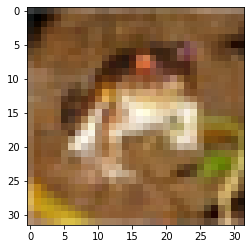

In [ ]:
plt.imshow((x_train[0]+1)/2)

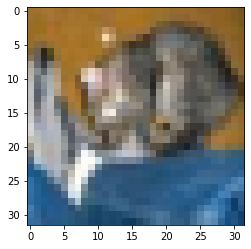

In [ ]:
plt.imshow((x_test_normal[0]+1)/2)

いつも通り訓練関数を作っておく

In [ ]:
d_history = []
g_history = []

def train(x_train, n_epochs=200, n_batch=128, x_val=x_test_normal):
    n_train = x_train.shape[0]
    bat_per_epoch = int(x_train.shape[0] / n_batch)
    y_real = np.ones((n_batch,))
    y_fake = np.zeros((n_batch,))
    y_dummy = np.zeros((n_batch, latent_dim)) # latent lossの計算にわたすy_true=0
    xhat_dummy = np.zeros((n_batch, )+ x_train.shape[1:]) # contextual lossの計算にわたすy_true=0

    for i in range(n_epochs):
        
        for j in range(bat_per_epoch):

            idxes = np.random.choice(list(range(n_train)), n_batch)
            x_batch_0 = x_train[idxes]
            idxes = np.random.choice(list(range(n_train)), n_batch)
            x_batch = x_train[idxes]
            xhat_batch = generator.predict(x_batch)
            
            d_loss = gan_D.train_on_batch([x_batch_0, x_batch, xhat_batch], [y_real, y_fake, y_dummy])
            d_history.append(d_loss)

            idxes = np.random.choice(list(range(n_train)), n_batch)
            x_batch = x_train[idxes]
            g_loss = gan_G.train_on_batch(x_batch, [y_real, xhat_dummy, y_dummy])
            g_history.append(g_loss)

            if j  == 0:
                print('epoch', i)
                print('D', d_loss[0], ', G', g_loss[0])
                print('D adv loss real', d_loss[1], ', D adv loss fake',  d_loss[2], ', D latent loss', d_loss[3])
                print('G adv loss', g_loss[1], 'G contextual loss', g_loss[2], 'G latent loss', g_loss[3])
                # 複数枚表示するようにした方が良い
                xhat_val = generator.predict(x_val[:1])
                plt.imshow((xhat_val[0,:,:,:]+1)/2)
                plt.axis("off")
                plt.show()
            # 5エポック以降は重みを保存
            if i>4:
                gan_G.save_weights(DATASET_PATH + '/skip_GANomaly_%sepochs.h5' % i)

では学習です。本当はちゃんと`x_val`をつくって最後の引数に渡してください。

原論文に従い、15エポック学習させる：

epoch 0
D 1.4319365 , G 19.47892
D adv loss real 0.7138454 , D adv loss fake 0.6401634 , D latent loss 0.077927716
G adv loss 0.12785655 G contextual loss 0.4837564 G latent loss 0.0008068306


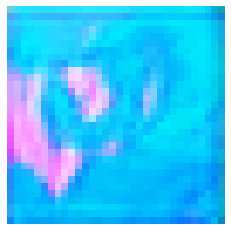

epoch 1
D 1.3862947 , G 1.8200057
D adv loss real 0.69314194 , D adv loss fake 0.6931528 , D latent loss 3.0893693e-12
G adv loss 0.69315135 G contextual loss 0.028171357 G latent loss 3.8386963e-12


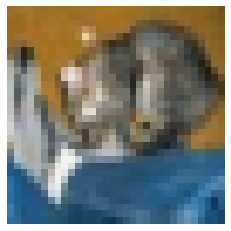

epoch 2
D 1.3862941 , G 1.6022235
D adv loss real 0.6931195 , D adv loss fake 0.6931746 , D latent loss 1.8252721e-12
G adv loss 0.6931335 G contextual loss 0.022727251 G latent loss 1.121649e-12


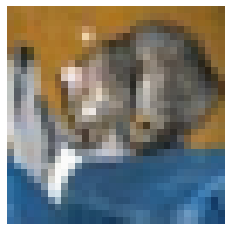

epoch 3
D 1.3862917 , G 1.3237374
D adv loss real 0.6931462 , D adv loss fake 0.69314545 , D latent loss 4.8486237e-13
G adv loss 0.693145 G contextual loss 0.015764812 G latent loss 4.992536e-13


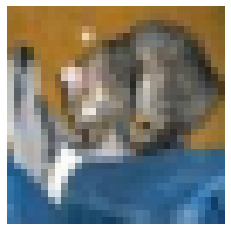

epoch 4
D 1.3862888 , G 1.2398334
D adv loss real 0.6931446 , D adv loss fake 0.69314414 , D latent loss 6.689403e-13
G adv loss 0.6931444 G contextual loss 0.013667222 G latent loss 4.66147e-13


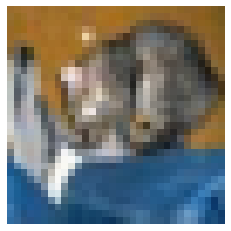

epoch 5
D 1.3862945 , G 1.1706705
D adv loss real 0.69309485 , D adv loss fake 0.69319963 , D latent loss 1.5449996e-12
G adv loss 0.6932006 G contextual loss 0.0119367475 G latent loss 1.7746011e-12


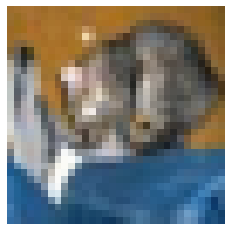

epoch 6
D 1.3862951 , G 1.2071359
D adv loss real 0.6940554 , D adv loss fake 0.69223976 , D latent loss 2.8793504e-13
G adv loss 0.69212484 G contextual loss 0.012875278 G latent loss 3.0446587e-13


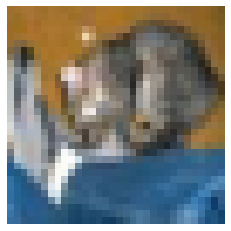

epoch 7
D 1.3862939 , G 1.1772342
D adv loss real 0.6931397 , D adv loss fake 0.6931543 , D latent loss 1.03384423e-13
G adv loss 0.6931551 G contextual loss 0.012101976 G latent loss 1.07131745e-13


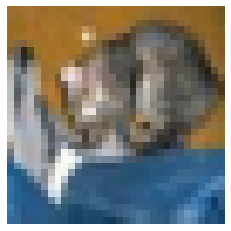

epoch 8
D 1.3862944 , G 1.2263459
D adv loss real 0.6931454 , D adv loss fake 0.69314903 , D latent loss 4.569734e-14
G adv loss 0.6931493 G contextual loss 0.013329914 G latent loss 5.8625054e-14


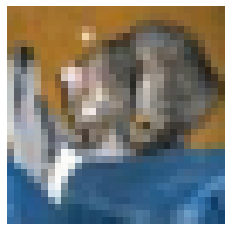

epoch 9
D 1.3862944 , G 1.3028538
D adv loss real 0.69314814 , D adv loss fake 0.6931462 , D latent loss 7.079021e-14
G adv loss 0.69314545 G contextual loss 0.015242707 G latent loss 6.367183e-14


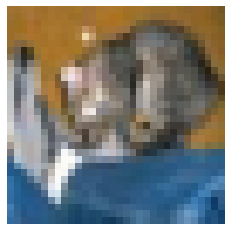

epoch 10
D 1.3862932 , G 0.980127
D adv loss real 0.69313353 , D adv loss fake 0.6931597 , D latent loss 1.5541725e-13
G adv loss 0.69315886 G contextual loss 0.0071742022 G latent loss 1.5235416e-13


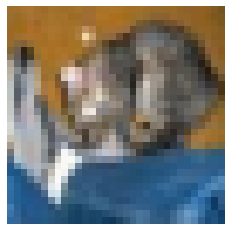

In [ ]:
train(x_train, n_epochs=16, n_batch=32, x_val=x_test_normal)

学習曲線

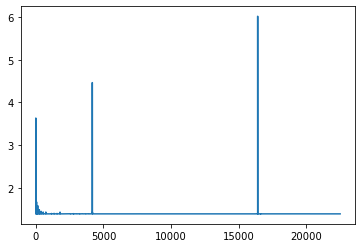

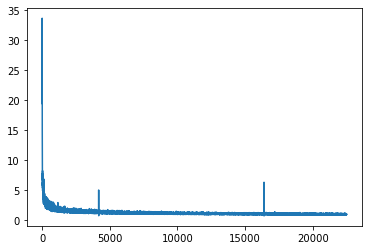

In [ ]:
d_losses = np.array(d_history)[:,0]
g_losses = np.array(g_history)[:,0]

plt.plot(d_losses)
plt.show()

plt.plot(g_losses)
plt.show()

# 4. 学習済みモデルの評価

異常スコアを計算する関数を実装しておく：

In [ ]:
def anomaly_score(x_batch, pred_model=gan_G, lam=0.9):
    _, x_subtruct, feat_subtruct = pred_model.predict(x_batch)
    R = np.mean(np.abs(x_subtruct), axis=(1,2,3))
    L = np.mean(feat_subtruct**2, axis=-1)
    A = lam*R + (1-lam)*L
    return A

早速、学習済みモデルをテストしてみよう。すぐさま過学習するので、エポック選択が重要だが、ここではsloppyにテストデータで見てしまおう（本当は検証データでエポック数を選ぶこと！! このように選んだ結果を論文に書いたら、これはモデル選択を介した典型的なスヌーピングです。）

<b>6エポック</b>

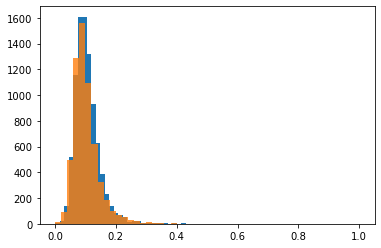

In [ ]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_5epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

<b>7エポック</b>

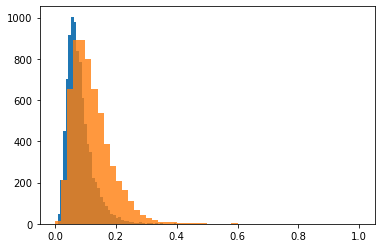

In [ ]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_6epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

<b>8エポック</b>

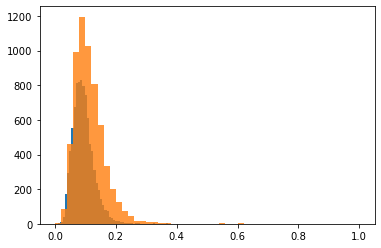

In [ ]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_7epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

<b>9エポック</b>

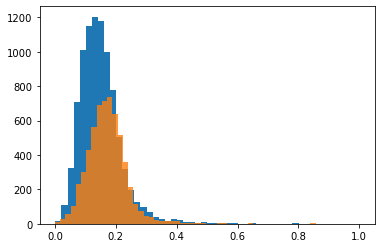

In [ ]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_8epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

# 問題

学習済みの重み（7エポック）を配布したので、このモデルに対して異常検知のAUCを測りましょう。

また、y=0以外のクラスについても学習させ、異常カテゴリごとのAUCの違いを観察せよ（GANomalyなどの論文の結果と比べてみるとよい）。

またこの実装が原実装の細部を再現している保証はないので、詳しく調べてこのコードを改善せよ（そして調査結果を私に教えてください…）。